In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
import lseg.data as ld
ld.open_session()


<lseg.data.session.Definition object at 0x3076037d0 {name='workspace'}>

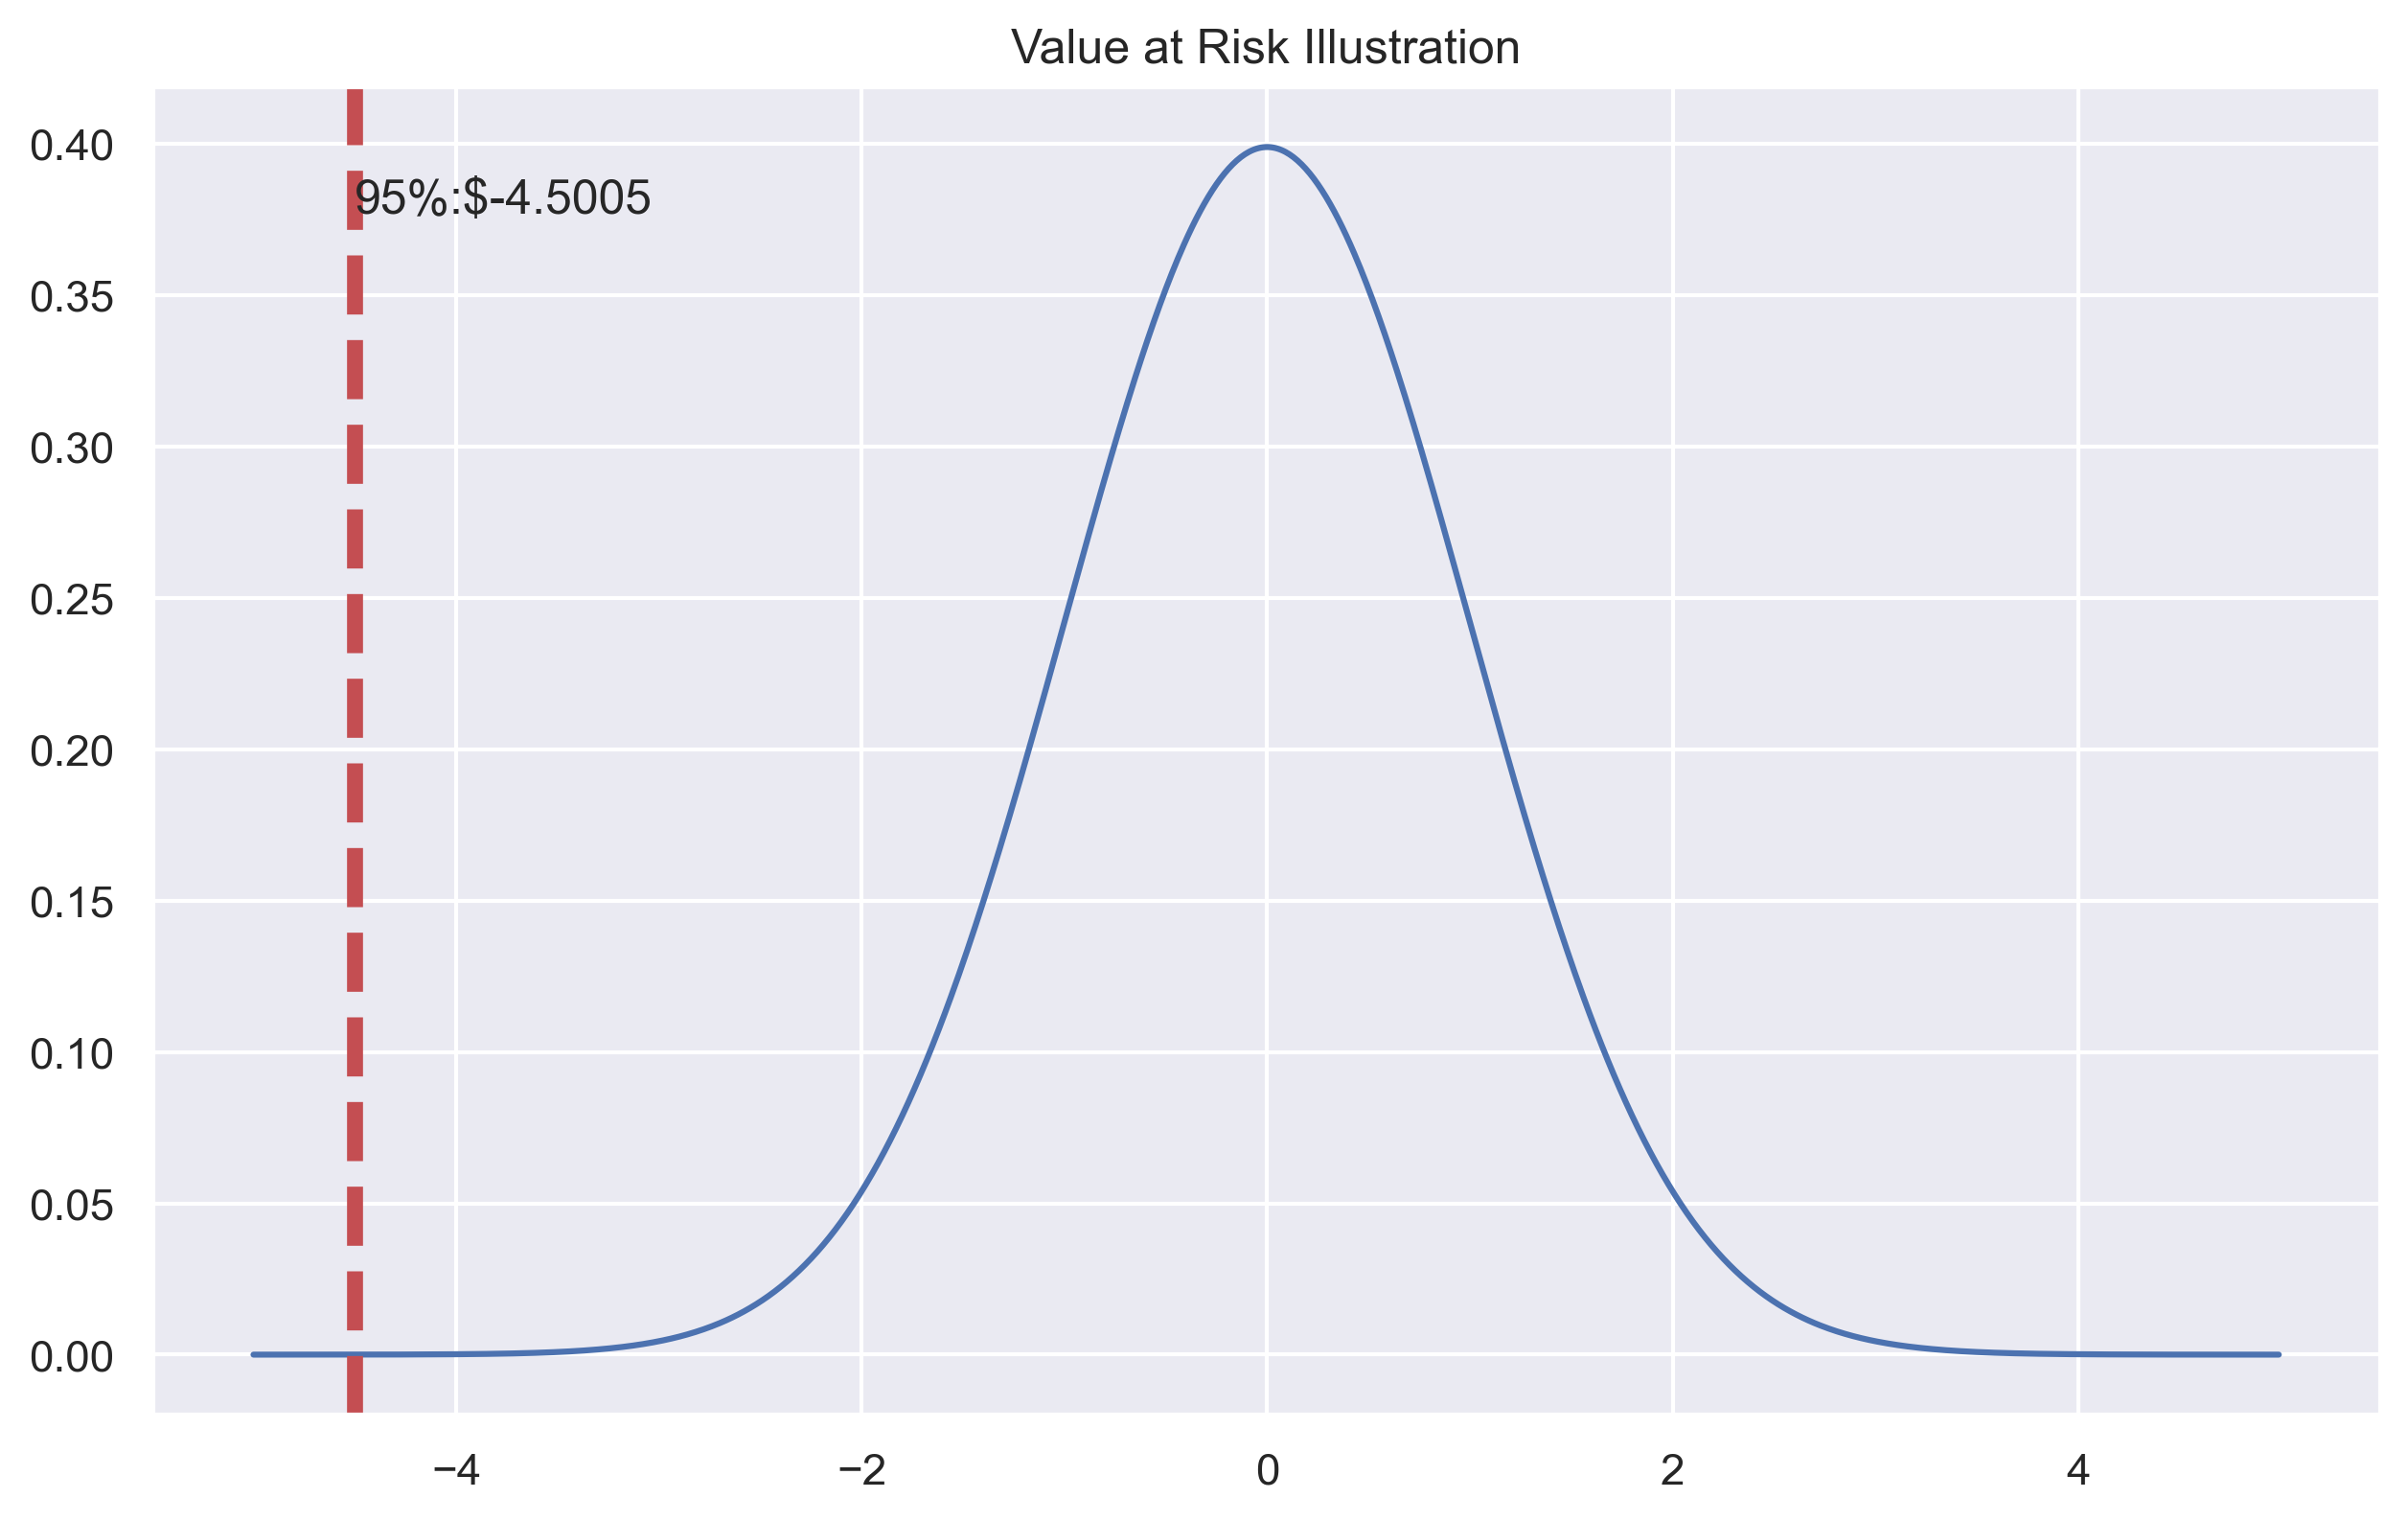

In [3]:
mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [4]:
RICS = ["TSLA.N", "MSFT.O", "NVDA.O"]
ts = ld.get_data(RICS,
                   [
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D).date',
                    'TR.PriceClose(SDate=2021-01-02,EDate=2025-10-01,Frq=D)'
                   ])
ts2 = ts.drop_duplicates()
ts2

,Instrument,Date,Price Close
0,TSLA.N,2021-01-04,243.29309
1,TSLA.N,2021-01-05,245.036422
2,TSLA.N,2021-01-06,252.063081
3,TSLA.N,2021-01-07,272.039728
4,TSLA.N,2021-01-08,293.379707
...,...,...,...
3570,NVDA.O,2025-09-24,176.97
3571,NVDA.O,2025-09-25,177.69
3572,NVDA.O,2025-09-26,178.19
3573,NVDA.O,2025-09-29,181.85


In [5]:
stocks = ts2.pivot(index="Date", columns="Instrument", values="Price Close")
stocks

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-04,217.69,13.1135,243.29309
2021-01-05,217.9,13.40475,245.036422
2021-01-06,212.25,12.6145,252.063081
2021-01-07,218.29,13.344,272.039728
2021-01-08,219.62,13.27675,293.379707
...,...,...,...
2025-09-25,507.03,177.69,423.37
2025-09-26,511.46,178.19,440.295
2025-09-29,514.6,181.85,443.385


In [6]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

Instrument,MSFT.O,NVDA.O,TSLA.N
Date,,,
2021-01-05,0.000964,0.021967,0.00714
2021-01-06,-0.026271,-0.060762,0.028273
2021-01-07,0.02806,0.05622,0.076269
2021-01-08,0.006074,-0.005052,0.07552
2021-01-11,-0.009746,0.025635,-0.082121
...,...,...,...
2025-09-24,0.001805,-0.008216,0.039368
2025-09-25,-0.006135,0.00406,-0.044668
2025-09-26,0.008699,0.00281,0.039198


In [7]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
weights =  np.array([.333, .333, .333], dtype='float')
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [8]:
weights

array([0.333, 0.333, 0.333])

In [9]:
stocks_returns_mean

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64

In [10]:
print(stocks_returns_mean)
print(weights)
print(cov_var)
print(port_std) 

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64
[0.333 0.333 0.333]
Instrument    MSFT.O    NVDA.O    TSLA.N
Instrument                              
MSFT.O      0.000268  0.000345  0.000269
NVDA.O      0.000345  0.001095  0.000602
TSLA.N      0.000269  0.000602  0.001491
0.024210348997447277


In [11]:
#weights = np.array([.2,.3,.4])

In [12]:
stocks_returns_mean = stocks_returns.mean()
stocks_returns_mean

Instrument
MSFT.O    0.000728
NVDA.O    0.002231
TSLA.N    0.000507
dtype: Float64

In [13]:
initial_investment = 1000000
conf_level = 0.95

In [14]:
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [15]:
port_std

0.024210348997447277

In [16]:
alpha = norm.ppf(.05, stocks_returns_mean, port_std)

In [17]:
alpha

array([-0.03909407, -0.0375912 , -0.03931557])

In [18]:
stocks.columns

Index(['MSFT.O', 'NVDA.O', 'TSLA.N'], dtype='string', name='Instrument')

## Variance-Covariance Method

In [19]:
for i, j in zip(stocks.columns, range(len(stocks.columns))):
    VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
    print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))

Parametric VaR result for MSFT.O is 39094.07138334552 
Parametric VaR result for NVDA.O is 37591.204839211656 
Parametric VaR result for TSLA.N is 39315.57027976541 


In [20]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [21]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for MSFT.O is 39094.07138334541 
Parametric VaR result for NVDA.O is 37591.204839211656 
Parametric VaR result for TSLA.N is 39315.57027976541 
--------------------------------------------------


array([39094.07138335, 37591.20483921, 39315.57027977])

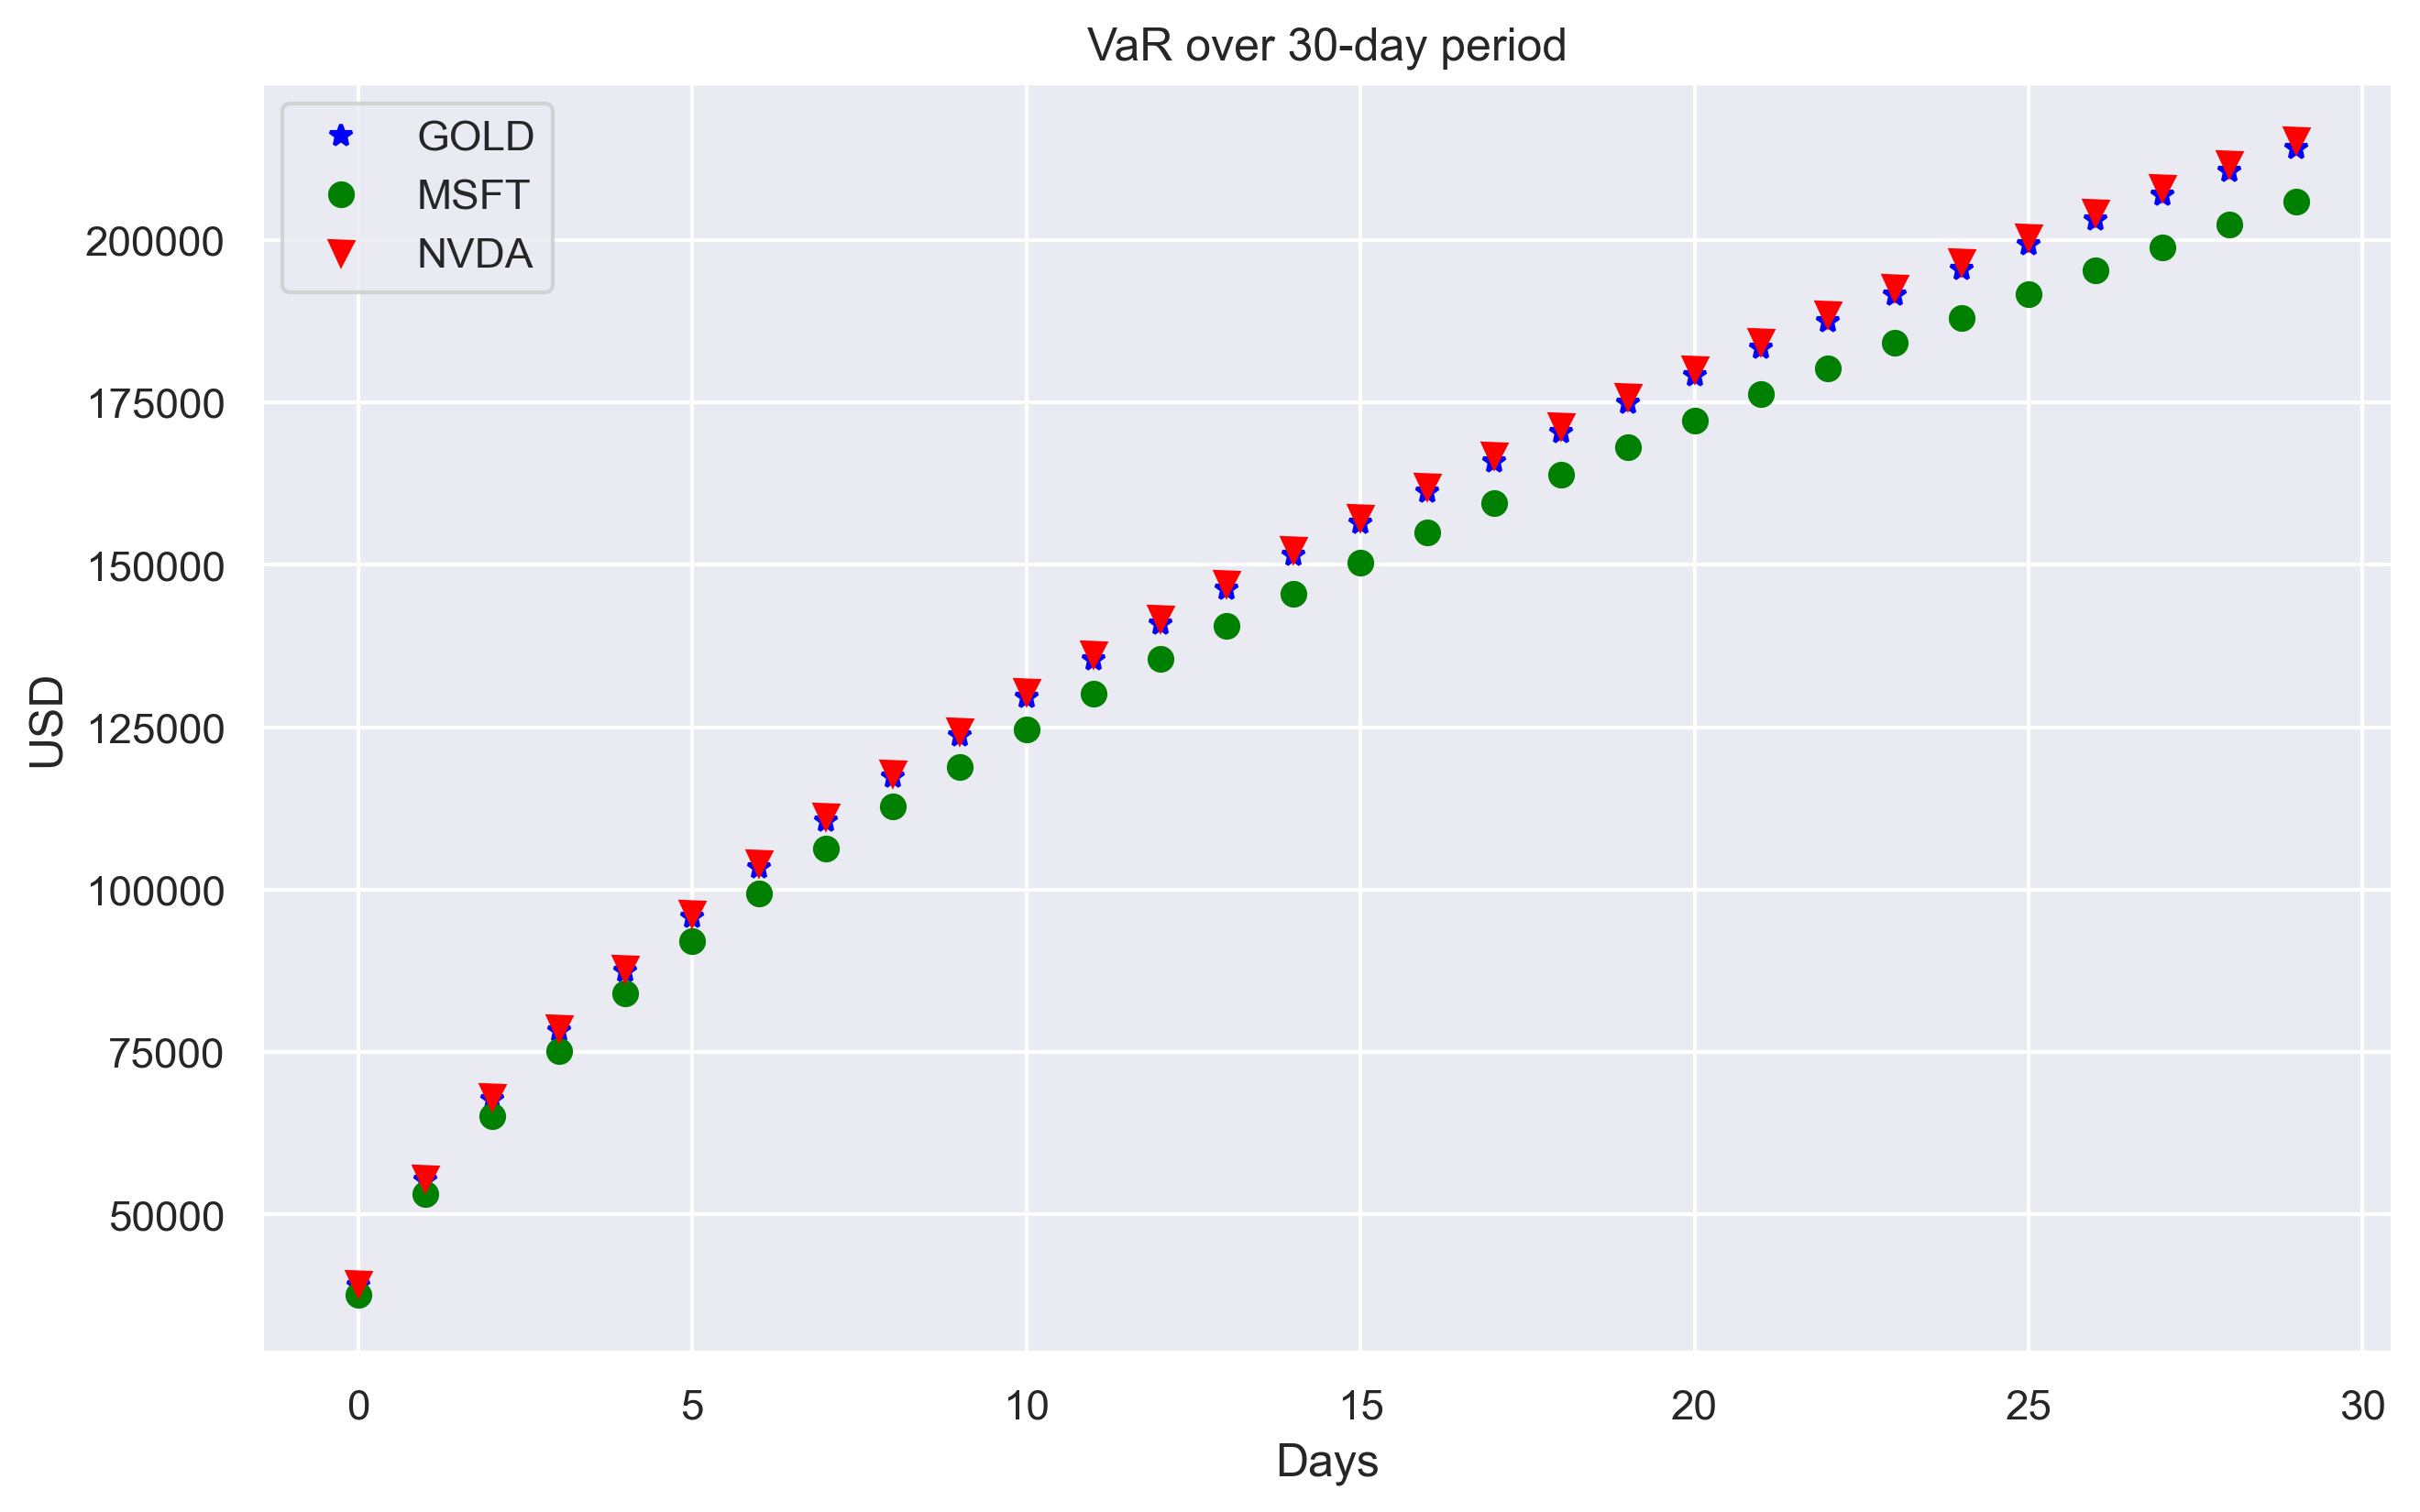

In [22]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='GOLD')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='NVDA')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical


In [23]:
for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
    print(np.percentile(stocks_returns.loc[:, i], 5))

-0.026801661188673487
-0.05131181406631904
-0.06154277460248707


In [24]:
stocks_returns.loc[:, 'NVDA.O']

Date
2021-01-05    0.021967
2021-01-06   -0.060762
2021-01-07     0.05622
2021-01-08   -0.005052
2021-01-11    0.025635
                ...   
2025-09-24   -0.008216
2025-09-25     0.00406
2025-09-26     0.00281
2025-09-29    0.020332
2025-09-30    0.025678
Name: NVDA.O, Length: 1190, dtype: Float64

In [25]:
np.percentile(stocks_returns.loc[:, 'NVDA.O'], 5)

-0.05131181406631904

In [26]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [27]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of MSFT.O's return is -0.0268
Historical VaR result for MSFT.O is 26801.66 
----------------------------------------------------------------------
Based on historical values 95% of NVDA.O's return is -0.0513
Historical VaR result for NVDA.O is 51311.81 
----------------------------------------------------------------------
Based on historical values 95% of TSLA.N's return is -0.0615
Historical VaR result for TSLA.N is 61542.77 
----------------------------------------------------------------------


## Monte Carlo VaR

In [28]:
x = np.random.uniform(-1, 1, 100) 
y = np.random.uniform(-1, 1, 100)

In [29]:
y

array([-6.11767802e-01,  7.23123898e-01, -5.07041785e-01, -3.33232913e-01,
       -8.12271436e-01, -9.33475662e-01,  1.60733034e-01,  9.42344793e-01,
       -2.00113650e-01,  4.72229831e-02,  9.11723667e-01, -2.72064475e-01,
        3.45223944e-01,  7.26851844e-01, -9.47065772e-01,  3.86008207e-01,
       -6.93983609e-01, -8.00643241e-01,  9.59420367e-01,  8.55349613e-01,
        4.25107237e-01,  1.41039363e-01, -6.38306554e-01, -1.15754313e-01,
       -9.66050342e-04, -7.60860662e-01,  3.00677712e-01, -3.93010880e-01,
        7.98391030e-01,  5.64692260e-01, -6.95795581e-01,  5.04541309e-01,
        6.69330930e-01, -1.97168848e-01, -7.27345197e-02, -1.05151423e-01,
        1.12731131e-01,  9.08433613e-01, -4.87814656e-01,  1.86387603e-01,
       -3.59910977e-01,  3.67256551e-01,  4.75274419e-01, -1.88806270e-01,
        9.40641916e-03,  9.09021561e-01,  2.33504584e-01,  6.43398936e-01,
       -6.98715714e-01,  4.45798344e-01, -2.43219696e-01,  9.20059694e-01,
       -5.79136237e-01,  

In [30]:
x

array([ 0.42037053,  0.03195699, -0.92272413,  0.7554781 ,  0.03164185,
       -0.00656286,  0.16221471,  0.58492718, -0.43542299,  0.56040591,
       -0.8893153 , -0.91703622, -0.69997598,  0.58849516,  0.12338474,
       -0.57390718, -0.10072587,  0.75321876, -0.0319071 , -0.49774122,
        0.61562666,  0.9501305 ,  0.76265099,  0.93452345, -0.53266408,
       -0.62981018,  0.54633594, -0.85105577,  0.80687124,  0.39858274,
       -0.03210513, -0.86329216,  0.4569483 ,  0.84685573, -0.80166899,
       -0.22951758,  0.24814871, -0.64456742,  0.88065323, -0.38071179,
       -0.94356816, -0.35993042, -0.41994014,  0.83117827,  0.92248493,
       -0.26980656, -0.14234111, -0.53129311, -0.16810615,  0.49437703,
       -0.51154641,  0.65819084,  0.91704454,  0.199637  , -0.35414274,
        0.37721656, -0.15380386, -0.58138233,  0.84356324, -0.04045661,
       -0.6792498 ,  0.07446449, -0.6745162 , -0.25127511, -0.7373122 ,
        0.86692146, -0.7272904 ,  0.55131223,  0.9874773 , -0.93

In [31]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [32]:
pi_calc(x,y)

pi value is 3.36


In [33]:
len(stocks.columns)

3

In [34]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    print(i)

0
1
2


In [35]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [36]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,-0.715947,-1.405686,0.773684
1,-2.677898,1.586201,1.268480
2,0.225226,0.021024,-0.753791
3,-0.984670,0.522322,-1.489576
4,0.471254,-0.768335,2.054874
...,...,...,...
995,-0.843664,0.423683,0.331119
996,-0.891610,-0.334398,1.619233
997,-1.109547,0.701021,-0.936314
998,-0.732010,-0.620265,0.878208


In [37]:
MC_percentile95 = []
for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
    print(i,j)

Simulation 1 0
Simulation 2 1
Simulation 3 2


In [38]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [39]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.6542
Simulation VaR result for Simulation 1 is 1654180.93 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.4563
Simulation VaR result for Simulation 2 is 1456253.86 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.5591
Simulation VaR result for Simulation 3 is 1559095.25 
----------------------------------------------------------------------
